# Inference on pretrained SSD model using Tensor Cores

In this tutorial we will show, how to run an inference with our SSD implementation.

We will start with defining input pipeline, then we will see how to load the model and then we will run an inference.

## Loading an image

Lets import libraries we will use to prepare an input image.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch

%matplotlib inline

From our examples we can import utility functions for inference:

In [2]:
from dle.inference import load_image, rescale, crop_center, normalize

Now, we can load an example image.

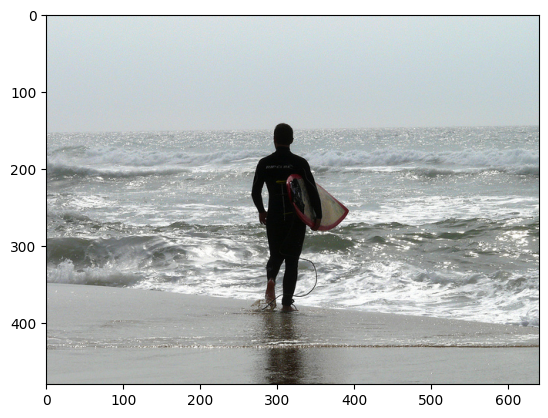

In [3]:
#img = load_image('http://images.cocodataset.org/val2017/000000397133.jpg')
img = load_image('../data/coco/images/val2014/COCO_val2014_000000001369.jpg')
plt.imshow(img)

Next we will rescale it, crop it and normalize it, so the model will get the expected input:

In [4]:
img = rescale(img, 300, 300)
img = crop_center(img, 300, 300)
img = normalize(img)

We can present the image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


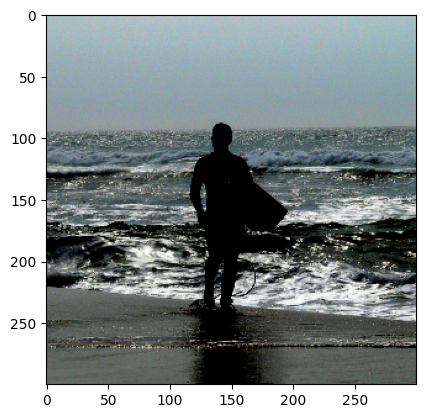

In [5]:
plt.imshow(img)

I looks weird, because after normalization, data values are in range [-1..1]. Plotting lib expects values from [0..1] range. We can fix it for visualization purpose:

(300, 300, 3)

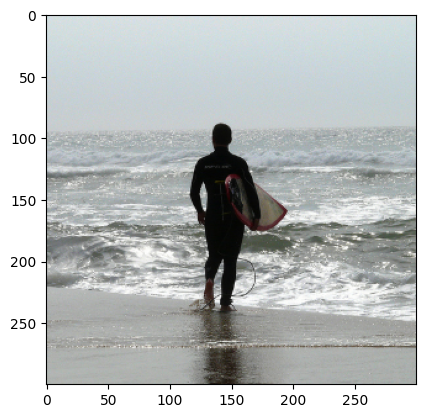

In [6]:
out = img/2+0.5
plt.imshow(out)
img.shape

## Building an predictor

We have prepared our imput. Next thing is to load a SSD model.
In our examples you can find some framework specific functions. Some of them will be explained here in detail.

In [7]:
from examples.SSD300_inference import load_checkpoint, build_predictor

Now we can import the model. We need to set it in the evaluation mode also:

In [8]:
from apex.fp16_utils import network_to_half

#ssd300 = build_predictor('/checkpoints/SSD300v1.1.pt')
ssd300 = build_predictor('../checkpoints/coco/epoch_19.pt',81)
ssd300 = ssd300.cuda()
ssd300 = network_to_half(ssd300.cuda())
ssd300 = ssd300.eval()

The model does not expect input as a `ndarray`. It prefers Pytorch Tensor data format. It also expects that input will be a batch of several images. What is more, it expects input in a bit different shape than usual.
We can fulfill these requirements with following code:

In [9]:
# change the shape
HWC = img
CHW = np.swapaxes(np.swapaxes(HWC, 0, 2), 1, 2)
# make a batch of 1 image
batch = np.expand_dims(CHW, axis=0)
# turn input into tensor
tensor = torch.from_numpy(batch)
tensor = tensor.cuda()
tensor = tensor.half()
tensor.shape

torch.Size([1, 3, 300, 300])

## Running prediction

Finally, we can make some prediction:

In [10]:
prediction = ssd300(tensor)

However, the output from the model is not too easy to read. To present it in human-readable form there are a few steps missing.

At first, more imports...

In [11]:
from ssd.utils import dboxes300_coco, Encoder
import matplotlib.patches as patches
import json

Which allows us to decode the result:

In [12]:
dboxes = dboxes300_coco()
encoder = Encoder(dboxes)
ploc, plabel = [val.float() for val in prediction]
encoded = encoder.decode_batch(ploc, plabel, criteria=0.5, max_output=20)

A `criteria` param allows to filter results with IoU not lower than the `criteria`.

Encoder returns a batch of results in a form:
```
[ fst img: prediction,
  snd_img: prediction,
  ...
]
```
While the prediction is:
```
( bounding boxes: [ fst detection: [x1, y1, x2, y2], snd detection ... ],
  classes:        [ fst detextion: class idx,        snd detection ... ],
  confidences:    [ fst detextion: confidence,       snd detection ... ]
)
```

Now we cant take the result bact to the numpy world and put results on an image.
We have single input image, then we will get rid of the batch also:

In [13]:
bboxes, classes, confidences = [x.detach().cpu().numpy() for x in encoded[0]]

Next, we can filter results with confidence lower than some treshold:

In [17]:
best = np.argwhere(confidences > 0.3).squeeze(axis=1)

To show labels on the detections we need to decode labels. Our model is trained on COCO 2017 dataset. Then we will use labels from COCO:

In [18]:
#json_file = '/datasets/coco2017/annotations/instances_val2017.json'
json_file = '../data/coco/annotations/instances_val2014.json'
with open(json_file,'r') as COCO:
    js = json.loads(COCO.read())
class_names = [ category['name'] for category in js['categories'] ]

Now we can start building the picture with results.
Bounding boxes returned by the model are enclosed in a [0..1] range. We need to scale it to [0..300], as it is the size of the image.

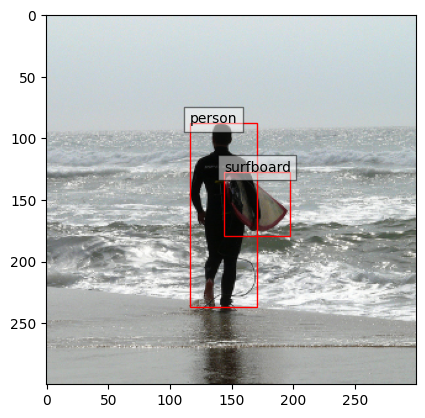

In [19]:
fig,ax = plt.subplots(1)
ax.imshow(out)
for idx in best:
    left, top, right, bottom = bboxes[idx]
    x, y, w, h = [val*300 for val in [left, top, right-left, bottom-top]]
    rect = patches.Rectangle((x, y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y, class_names[classes[idx]-1], bbox=dict(facecolor='white', alpha=0.5))
plt.show()